# GradCAM Visualization Demo with ResNet101

Requirement:

* GPU Memory: 6GB or higher


In [1]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

/home/naver/Documents/tf1.3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


cost: Tensor("mul:0", shape=(3,), dtype=float32)
y_c: Tensor("Sum_1:0", shape=(3,), dtype=float32)
INFO:tensorflow:Restoring parameters from model/resnet_v1_101.ckpt
Top1:  n02108422 bull mastiff 0.251916
Top5:  [('n02108422 bull mastiff', 0.25191587), ('n02109047 Great Dane', 0.14613843), ('n02108089 boxer', 0.049656909), ('n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier', 0.034811515), ('n02088466 bloodhound, sleuthhound', 0.033809826)]
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 224, 3)


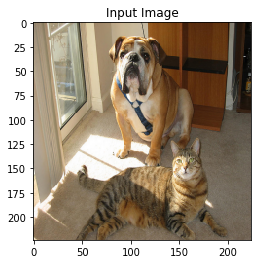

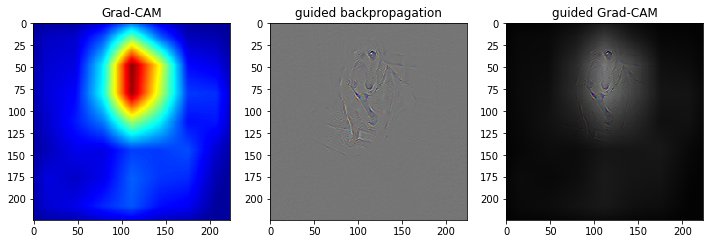

Top1:  n02086240 Shih-Tzu 0.340485
Top5:  [('n02086240 Shih-Tzu', 0.34048459), ('n02098413 Lhasa, Lhasa apso', 0.12402648), ('n02085936 Maltese dog, Maltese terrier, Maltese', 0.054769825), ('n02086079 Pekinese, Pekingese, Peke', 0.049223062), ('n02086910 papillon', 0.030656578)]
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 224, 3)


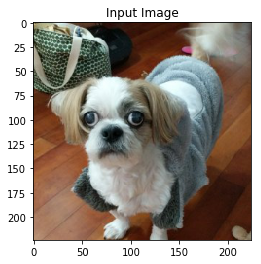

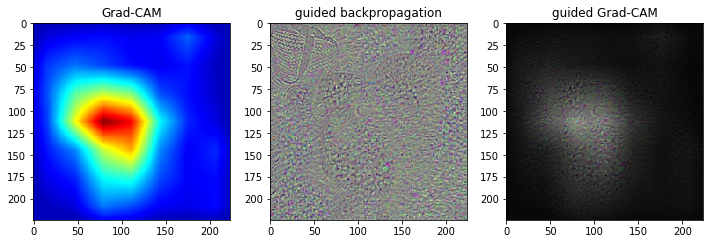

Top1:  n02129604 tiger, Panthera tigris 0.131988
Top5:  [('n02129604 tiger, Panthera tigris', 0.13198802), ('n02123159 tiger cat', 0.04696751), ('n02442845 mink', 0.021334752), ('n01807496 partridge', 0.018934023), ('n02356798 fox squirrel, eastern fox squirrel, Sciurus niger', 0.016134758)]
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 224, 3)


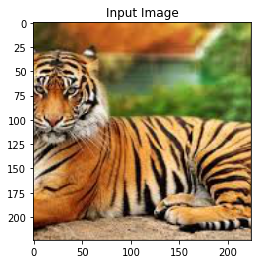

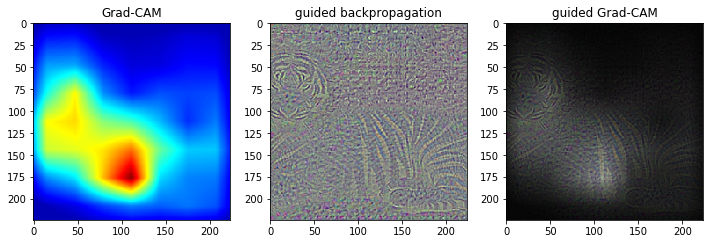

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from nets import resnet_v1
slim = tf.contrib.slim

import utils

# Create mini-batch for demo

img1 = utils.load_image("./demo.png", normalize=False)
img2 = utils.load_image("./shihtzu_mypuppy.jpg", normalize=False)
img3 = utils.load_image("./tiger.jpg", normalize=False)

batch1_img = img1.reshape((1, 224, 224, 3))
batch1_label = np.array([1 if i == 242 else 0 for i in range(1000)])  # 1-hot result for Boxer
batch1_label = batch1_label.reshape(1, -1)

batch2_img = img2.reshape((1, 224, 224, 3))
batch2_label = np.array([1 if i == 155 else 0 for i in range(1000)])  # 1-hot result for Shih-Tzu
batch2_label = batch2_label.reshape(1, -1)

batch3_img = img3.reshape((1, 224, 224, 3))
batch3_label = np.array([1 if i == 292 else 0 for i in range(1000)])  # 1-hot result for tiger
batch3_label = batch3_label.reshape(1, -1)

batch_img = np.concatenate((batch1_img, batch2_img, batch3_img), 0)
batch_label = np.concatenate((batch1_label, batch2_label, batch3_label), 0)
batch_size = 3

# batch_img = np.concatenate((batch1_img), 0)
# batch_label = np.concatenate((batch1_label), 0)
# batch_size = 1
# batch_label = batch_label.reshape(batch_size, -1)

# Create tensorflow graph for evaluation
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        images = tf.placeholder("float", [batch_size, 224, 224, 3])
        labels = tf.placeholder(tf.float32, [batch_size, 1000])
        
        preprocessed_images = utils.resnet_preprocess(images)
        
        with slim.arg_scope(resnet_v1.resnet_arg_scope()):
            with slim.arg_scope([slim.batch_norm], is_training=False):
                # is_training=False means batch-norm is not in training mode. Fixing batch norm layer.
                # net is logit for resnet_v1. See is_training messing up issue: https://github.com/tensorflow/tensorflow/issues/4887
                net, end_points = resnet_v1.resnet_v1_101(preprocessed_images, 1000)
        prob = end_points['predictions'] # after softmax
        
        cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(prob)), axis=1)
        print('cost:', cost)
        y_c = tf.reduce_sum(tf.multiply(net, labels), axis=1)
        print('y_c:', y_c)

        # Get last convolutional layer gradient for generating gradCAM visualization
        # print('endpoints:', end_points.keys())
        target_conv_layer = end_points['resnet_v1_101/block4/unit_2/bottleneck_v1']
        target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

        # Guided backpropagtion back to input layer
        gb_grad = tf.gradients(cost, images)[0]

        init = tf.global_variables_initializer()
        
        # Load resnet v1 weights
        
        # latest_checkpoint = tf.train.latest_checkpoint("model/resnet_v1_50.ckpt")
        latest_checkpoint = "model/resnet_v1_101.ckpt"
        ## Optimistic restore.
        reader = tf.train.NewCheckpointReader(latest_checkpoint)
        saved_shapes = reader.get_variable_to_shape_map()
        variables_to_restore = tf.global_variables()
        for var in variables_to_restore:
          if not var.name.split(':')[0] in saved_shapes:
            print("WARNING. Saved weight not exists in checkpoint. Init var:", var.name)
          else:
            # print("Load saved weight:", var.name)
            pass

        var_names = sorted([(var.name, var.name.split(':')[0]) for var in variables_to_restore
                if var.name.split(':')[0] in saved_shapes])
        restore_vars = []
        with tf.variable_scope('', reuse=True):
            for var_name, saved_var_name in var_names:
                try:
                    curr_var = tf.get_variable(saved_var_name)
                    var_shape = curr_var.get_shape().as_list()
                    if var_shape == saved_shapes[saved_var_name]:
                        # print("restore var:", saved_var_name)
                        restore_vars.append(curr_var)
                except ValueError:
                    print("Ignore due to ValueError on getting var:", saved_var_name) 
        saver = tf.train.Saver(restore_vars)
        
        
        
# Run tensorflow 

with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)    
    # sess.run(tf.local_variables_initializer())
    saver.restore(sess, latest_checkpoint)
    
    prob = sess.run(prob, feed_dict={images: batch_img})
    
    # gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: prob})
    gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: batch_label})    
    
    for i in range(batch_size):
        # print('See visualization of below category')
        # utils.print_prob(batch_label[i], './synset.txt')
        utils.print_prob(prob[i], './synset.txt')
        # print('gb_grad_value[i]:', gb_grad_value[i])
        # print('gb_grad_value[i] shape:', gb_grad_value[i].shape)
        utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])
    